In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
import math
import matplotlib.pyplot as plt



from tensorflow import keras


# ======================================
# Config general
# ======================================
T = 200  # número de steps de difusión
beta_start = 1e-4
beta_end   = 2e-2

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Device:", device)

Device: mps


In [18]:
from torchinfo import summary

ModuleNotFoundError: No module named 'torchinfo'

In [2]:
# ======================================
# Definimos el schedule β_t lineal
# ======================================
betas = torch.linspace(beta_start, beta_end, T, device=device)       # (T,)
alphas = 1.0 - betas                                                 # (T,)
alphas_bar = torch.cumprod(alphas, dim=0)                            # (T,)

# helpers para indexar por t (shape batch)
def extract(a, t, x_shape):
    """
    Extrae a[t] y le da forma broadcastable a x_shape.
    a: tensor 1D de longitud T
    t: tensor long de shape (B,) con valores en [0, T-1]
    """
    out = a.gather(-1, t)     # (B,)
    return out.view(-1, 1, 1, 1).expand(x_shape)


# ======================================
# Proceso directo x_t(x0, eps)
#   x_t = sqrt(alpha_bar_t) x0 + sqrt(1-alpha_bar_t) eps
# ======================================
def q_sample(x0, t, noise=None):
    """
    x0: (B,1,28,28) en [-1,1] o [0,1]
    t:  (B,) long con tiempos
    noise: eps ~ N(0,I) de same shape que x0
    """
    if noise is None:
        noise = torch.randn_like(x0)
    sqrt_ab = extract(torch.sqrt(alphas_bar), t, x0.shape)
    sqrt_one_minus_ab = extract(torch.sqrt(1.0 - alphas_bar), t, x0.shape)
    return sqrt_ab * x0 + sqrt_one_minus_ab * noise, noise


#   Punto 4

In [3]:
class TimeEmbedding(nn.Module):
    def __init__(self, dim, max_steps=1000):
        super().__init__()
        self.dim = dim
        self.max_steps = max_steps

        # embedding sinusoidal
        self.half_dim = dim // 2
        self.freqs = torch.exp(
            -math.log(10000) * torch.arange(0, self.half_dim, dtype=torch.float32) / self.half_dim
        )

        # pequeño MLP para refinar
        self.mlp = nn.Sequential(
            nn.Linear(dim, dim),
            nn.SiLU(),
            nn.Linear(dim, dim),
        )

    def forward(self, t):
        """
        t: (B,) con enteros en [0, T-1]
        salida: (B, dim)
        """
        # pasamos t a float y normalizamos un poco
        t = t.float().unsqueeze(1)  # (B,1)
        freqs = self.freqs.to(t.device)  # (half_dim,)
        args = t * freqs  # (B, half_dim)

        # seno y coseno concatenados
        emb = torch.cat([torch.sin(args), torch.cos(args)], dim=-1)  # (B, dim)
        return self.mlp(emb)


In [4]:
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.act = nn.SiLU()

        # Proyección del embedding de tiempo a canales out_ch
        self.time_proj = nn.Linear(time_dim, out_ch)

    def forward(self, x, t_emb):
        """
        x: (B,C,H,W)
        t_emb: (B, time_dim)
        """
        # t_emb -> (B,out_ch,1,1) para sumarlo a los features
        temb = self.time_proj(t_emb)[:, :, None, None]

        h = self.conv1(x)
        h = h + temb
        h = self.act(h)
        h = self.conv2(h)
        h = self.act(h)
        return h


class UNet(nn.Module):
    def __init__(self, time_dim=128, base_ch=64):
        super().__init__()
        self.time_dim = time_dim

        # Embedding de tiempo
        self.time_mlp = TimeEmbedding(time_dim)

        # Encoder
        self.down1 = ConvBlock(1, base_ch, time_dim)
        self.down2 = ConvBlock(base_ch, base_ch * 2, time_dim)
        self.pool = nn.MaxPool2d(2)      # 28x28 -> 14x14
        # otro pool: 14x14 -> 7x7
        self.pool2 = nn.MaxPool2d(2)

        # Bottleneck
        self.bot = ConvBlock(base_ch * 2, base_ch * 4, time_dim)

        # Decoder
        self.up1 = nn.ConvTranspose2d(base_ch * 4, base_ch * 2, 2, stride=2)  # 7->14
        self.dec1 = ConvBlock(base_ch * 4, base_ch * 2, time_dim)

        self.up2 = nn.ConvTranspose2d(base_ch * 2, base_ch, 2, stride=2)  # 14->28
        self.dec2 = ConvBlock(base_ch * 2, base_ch, time_dim)

        # Proyección final a 1 canal (predicción de eps)
        self.out_conv = nn.Conv2d(base_ch, 1, 1)

    def forward(self, x, t):
        """
        x: (B,1,28,28)
        t: (B,)
        salida: eps_theta(x,t) con mismo shape que x
        """
        t_emb = self.time_mlp(t)  # (B,time_dim)

        # Encoder
        h1 = self.down1(x, t_emb)          # (B,64,28,28)
        h = self.pool(h1)                  # (B,64,14,14)
        h2 = self.down2(h, t_emb)          # (B,128,14,14)
        h = self.pool2(h2)                 # (B,128,7,7)

        # Bottleneck
        h = self.bot(h, t_emb)             # (B,256,7,7)

        # Decoder
        h = self.up1(h)                    # (B,128,14,14)
        h = torch.cat([h, h2], dim=1)      # skip
        h = self.dec1(h, t_emb)            # (B,128,14,14)

        h = self.up2(h)                    # (B,64,28,28)
        h = torch.cat([h, h1], dim=1)      # skip
        h = self.dec2(h, t_emb)            # (B,64,28,28)

        out = self.out_conv(h)             # (B,1,28,28)
        return out


#   Punto 5

In [5]:
def diffusion_loss(model, x0):
    """
    x0: batch de imágenes limpias (B,1,28,28)
    """
    B = x0.shape[0]
    # sample t uniforme en [0, T-1]
    t = torch.randint(0, T, (B,), device=device).long()

    # muestreamos x_t y el ruido real eps
    x_t, noise = q_sample(x0, t)  # noise ~ N(0,I)

    # predicción eps_theta(x_t, t)
    noise_pred = model(x_t, t)

    # loss L2
    return F.mse_loss(noise_pred, noise)


In [11]:
# ======================================
# Dataset MNIST
# ======================================
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
print(x_train.shape, y_train.shape)  # (60000, 28, 28) (60000,)

# ==============================
# Pasar a tensores de PyTorch
# ==============================

# a float32, normalizar a [0,1]
x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32") / 255.0

# si tu modelo espera [-1,1]:
x_train = 2.0 * x_train - 1.0
x_test  = 2.0 * x_test  - 1.0

# agregar canal (B, 1, 28, 28)
x_train = torch.from_numpy(x_train).unsqueeze(1)  # (N,1,28,28)
x_test  = torch.from_numpy(x_test).unsqueeze(1)   # (N,1,28,28)

# labels
y_train = torch.from_numpy(y_train).long()
y_test  = torch.from_numpy(y_test).long()

# datasets y loaders
train_dataset = TensorDataset(x_train, y_train)
test_dataset  = TensorDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=128, shuffle=False)


(60000, 28, 28) (60000,)


In [12]:
# ======================================
# Modelo + optimizador
# ======================================
model = UNet(time_dim=128, base_ch=64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)

n_epochs = 5  # arrancá con algo chico para probar

for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    for batch_idx, (x, y) in enumerate(train_loader):
        x = x.to(device)  # (B,1,28,28)

        optimizer.zero_grad()
        loss = diffusion_loss(model, x)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if (batch_idx + 1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{n_epochs}] "
                  f"Step [{batch_idx+1}/{len(train_loader)}] "
                  f"Loss: {running_loss / 100:.4f}")
            running_loss = 0.0


Epoch [1/5] Step [100/469] Loss: 0.4950
Epoch [1/5] Step [200/469] Loss: 0.2238
Epoch [1/5] Step [300/469] Loss: 0.1663
Epoch [1/5] Step [400/469] Loss: 0.1360
Epoch [2/5] Step [100/469] Loss: 0.1122
Epoch [2/5] Step [200/469] Loss: 0.0983
Epoch [2/5] Step [300/469] Loss: 0.0905
Epoch [2/5] Step [400/469] Loss: 0.0845
Epoch [3/5] Step [100/469] Loss: 0.0813
Epoch [3/5] Step [200/469] Loss: 0.0804
Epoch [3/5] Step [300/469] Loss: 0.0775
Epoch [3/5] Step [400/469] Loss: 0.0792
Epoch [4/5] Step [100/469] Loss: 0.0781
Epoch [4/5] Step [200/469] Loss: 0.0710
Epoch [4/5] Step [300/469] Loss: 0.0701
Epoch [4/5] Step [400/469] Loss: 0.0746
Epoch [5/5] Step [100/469] Loss: 0.0669
Epoch [5/5] Step [200/469] Loss: 0.0691
Epoch [5/5] Step [300/469] Loss: 0.0676
Epoch [5/5] Step [400/469] Loss: 0.0653


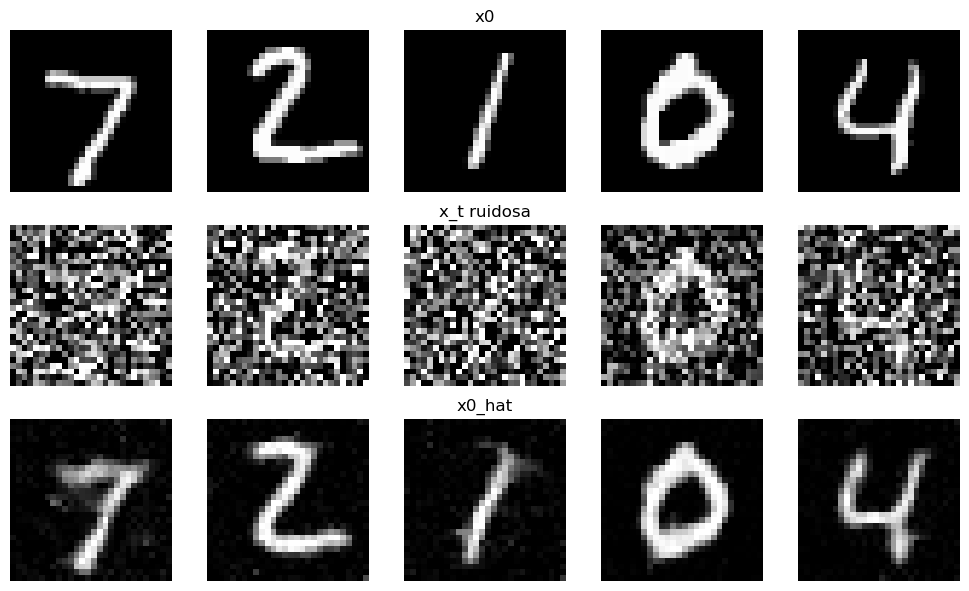

In [23]:
# ===========================
# Evaluación: un solo paso
# ===========================
model.eval()
x_clean, _ = next(iter(test_loader))
x_clean = x_clean.to(device)[:5]  # 8 imágenes
B = x_clean.size(0)

# Elegimos un tiempo relativamente grande (más ruido)
t_eval = torch.randint(low=int(0.5*T), high=T, size=(B,), device=device)

with torch.no_grad():
    # Proceso directo
    x_noisy, true_eps = q_sample(x_clean, t_eval)

    # Predicción de eps
    eps_pred = model(x_noisy, t_eval)

    # Reconstrucción aproximada de x0:
    # x0_hat = (x_t - sqrt(1-alpha_bar) * eps_pred) / sqrt(alpha_bar)
    sqrt_ab = extract(torch.sqrt(alphas_bar), t_eval, x_clean.shape)
    sqrt_one_minus_ab = extract(torch.sqrt(1. - alphas_bar), t_eval, x_clean.shape)
    x0_hat = (x_noisy - sqrt_one_minus_ab * eps_pred) / sqrt_ab

# Pasamos de [-1,1] a [0,1] para mostrar
def to_img(x):
    x = (x + 1.0) / 2.0
    return x.clamp(0,1)

x_clean_vis = to_img(x_clean.cpu())
x_noisy_vis = to_img(x_noisy.cpu())
x0_hat_vis  = to_img(x0_hat.cpu())

# Plot
fig, axes = plt.subplots(3, B, figsize=(B*2, 6))
for i in range(B):
    axes[0, i].imshow(x_clean_vis[i,0], cmap="gray")
    axes[0, i].axis("off")
    if i == 2:
        axes[0, i].set_title("x0")

    axes[1, i].imshow(x_noisy_vis[i,0], cmap="gray")
    axes[1, i].axis("off")
    if i == 2:
        axes[1, i].set_title("x_t ruidosa")

    axes[2, i].imshow(x0_hat_vis[i,0], cmap="gray")
    axes[2, i].axis("off")
    if i == 2:
        axes[2, i].set_title("x0_hat")

plt.tight_layout()
plt.show()
